In [2]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
%load_ext autoreload
%autoreload 2

In [ ]:
torch.manual_seed(50)

n_classes = 100
dim = 3
n_epochs = int(5e4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generate initial class vectors
U_init, V_init = generate_class_vectors(n_classes, dim, device)

# Make U and V learnable parameters and project them onto the unit sphere
U = nn.Parameter(U_init / torch.norm(U_init, dim=1, keepdim=True))
V = nn.Parameter(V_init / torch.norm(V_init, dim=1, keepdim=True))

# Initialize SigLIP loss with trainable temperature and bias
criterion = SigLIPLoss(temperature=10.0, relative_bias=-1.0).to(device)

# Create optimizer for U and V vectors
optimizer = torch.optim.Adam([
    {'params': U, 'lr': 0.01},
    {'params': V, 'lr': 0.01},
    {'params': criterion.parameters(), 'lr': 0.01}
])

# Training loop
losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = criterion(U, V)
    loss.backward()
    optimizer.step()
    
    # Project U and V back onto the unit sphere after optimization
    with torch.no_grad():
        U.data = U.data / torch.norm(U.data, dim=1, keepdim=True)
        V.data = V.data / torch.norm(V.data, dim=1, keepdim=True)
    
    # Store loss
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, '
              f'Temperature: {criterion.get_temperature():.4f}, '
              f'Relative bias: {criterion.get_bias():.4f}')

Epoch [100/50000], Loss: 0.2133, Temperature: 5.7183, Bias: -0.3139
Epoch [200/50000], Loss: 0.0599, Temperature: 5.8129, Bias: -0.2491
Epoch [300/50000], Loss: 0.0558, Temperature: 5.9008, Bias: -0.2306
Epoch [400/50000], Loss: 0.0542, Temperature: 5.9740, Bias: -0.2173
Epoch [500/50000], Loss: 0.0531, Temperature: 6.0441, Bias: -0.2056
Epoch [600/50000], Loss: 0.0521, Temperature: 6.1219, Bias: -0.1934
Epoch [700/50000], Loss: 0.0511, Temperature: 6.2099, Bias: -0.1803
Epoch [800/50000], Loss: 0.0502, Temperature: 6.3079, Bias: -0.1663
Epoch [900/50000], Loss: 0.0493, Temperature: 6.4164, Bias: -0.1513
Epoch [1000/50000], Loss: 0.0485, Temperature: 6.5342, Bias: -0.1357
Epoch [1100/50000], Loss: 0.0477, Temperature: 6.6594, Bias: -0.1197
Epoch [1200/50000], Loss: 0.0470, Temperature: 6.7909, Bias: -0.1035
Epoch [1300/50000], Loss: 0.0463, Temperature: 6.9275, Bias: -0.0873
Epoch [1400/50000], Loss: 0.0457, Temperature: 7.0689, Bias: -0.0712
Epoch [1500/50000], Loss: 0.0452, Temperatu

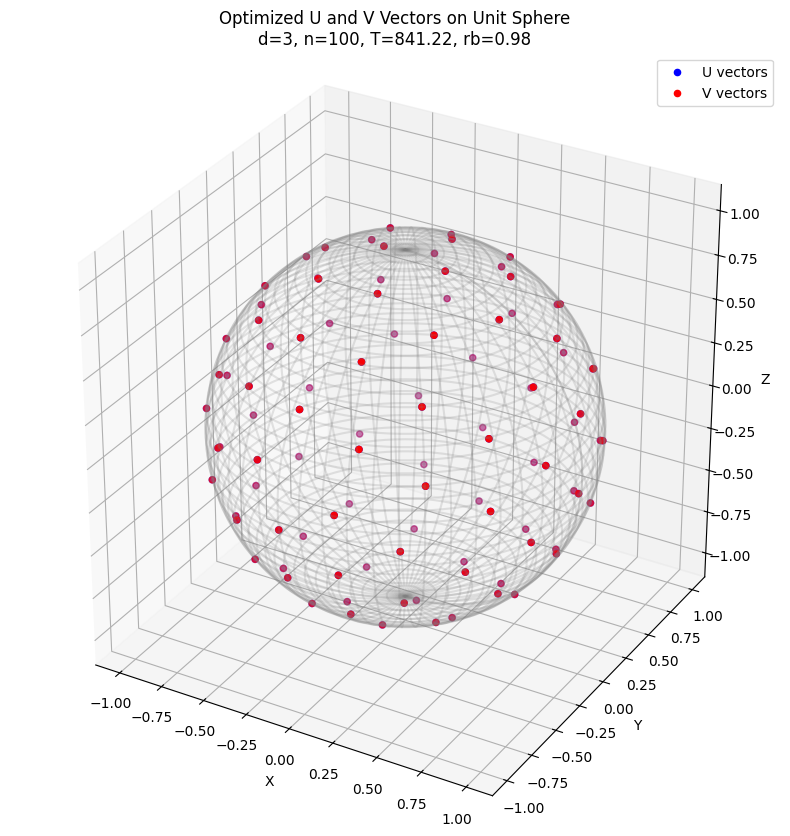

In [6]:
def plot_optimized_vectors(U, V, n_classes, criterion):
    """
    Plot the optimized U and V vectors on a unit sphere.

    Args:
        U (torch.Tensor): Tensor of U vectors of shape [n_classes, dim].
        V (torch.Tensor): Tensor of V vectors of shape [n_classes, dim].
        n_classes (int): Number of classes (or pairs of vectors).
        criterion (SigLIPLoss): The loss function to get final temperature and bias.
    """
    # Import visualization libraries
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np

    # Create a figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Move vectors to CPU and convert to numpy for plotting
    U_np = U.detach().cpu().numpy()
    V_np = V.detach().cpu().numpy()

    # Plot the unit sphere wireframe
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

    # Plot the points
    ax.scatter(U_np[:, 0], U_np[:, 1], U_np[:, 2], c='blue', label='U vectors')
    ax.scatter(V_np[:, 0], V_np[:, 1], V_np[:, 2], c='red', label='V vectors')

    # Draw lines between corresponding U and V vectors
    for i in range(n_classes):
        ax.plot([U_np[i, 0], V_np[i, 0]], 
                [U_np[i, 1], V_np[i, 1]], 
                [U_np[i, 2], V_np[i, 2]], 'k--', alpha=0.3)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Create title with additional information
    dim = U.shape[1]
    temp = criterion.get_temperature()
    relative_bias = criterion.get_bias()
    title = f'Optimized U and V Vectors on Unit Sphere\n'
    title += f'd={dim}, n={n_classes}, T={temp:.2f}, rb={relative_bias:.2f}'
    ax.set_title(title)
    
    ax.legend()

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    plt.show()

plot_optimized_vectors(U, V, n_classes, criterion)

In [7]:
# Compute inner products between all pairs of U and V vectors
inner_products = torch.matmul(U, V.T)

print("Inner products matrix:")
print(inner_products)

# Check diagonal elements (corresponding pairs)
diagonal = torch.diagonal(inner_products)
print("\nInner products for corresponding pairs (u_i · v_i):")
print(diagonal)
print(f"Mean inner product for corresponding pairs: {diagonal.mean():.4f}")

# Check off-diagonal elements (non-corresponding pairs)
mask = ~torch.eye(n_classes, dtype=bool)
off_diagonal = inner_products[mask]
print("\nInner products for non-corresponding pairs (u_i · v_j where i≠j):")
print(off_diagonal)
print(f"Mean inner product for non-corresponding pairs: {off_diagonal.mean():.4f}")

# Test the hypothesis
positive_diagonal = (diagonal > 0).all()
negative_off_diagonal = (off_diagonal < 0).all()

print("\nHypothesis test results:")
print(f"All corresponding pairs have positive inner product: {positive_diagonal}")
print(f"All non-corresponding pairs have negative inner product: {negative_off_diagonal}")


Inner products matrix:
tensor([[ 1.0000, -0.7587,  0.5485,  ...,  0.0369, -0.4779, -0.0241],
        [-0.7587,  1.0000, -0.9421,  ..., -0.6553,  0.8233,  0.2748],
        [ 0.5485, -0.9421,  1.0000,  ...,  0.7395, -0.7197, -0.5312],
        ...,
        [ 0.0369, -0.6553,  0.7395,  ...,  1.0000, -0.8378, -0.1347],
        [-0.4779,  0.8233, -0.7197,  ..., -0.8378,  1.0000, -0.1886],
        [-0.0241,  0.2749, -0.5312,  ..., -0.1348, -0.1885,  1.0000]],
       grad_fn=<MmBackward0>)

Inner products for corresponding pairs (u_i · v_i):
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.00